# Imports and configuration

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import axes3d
from xgboost import XGBClassifier
from datetime import date
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.decomposition import PCA, FastICA

# Will allow us to embed images in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 3)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

r = 666
np.random.seed(r)

# Loading original dataset

In [7]:
dataset = pd.read_csv('../common/dataset.csv', header=0, index_col='CUST_COD')
target = pd.read_csv('../common/target.csv', header=0, index_col='CUST_COD')
print(dataset.shape)
print(target.shape)

(26884, 24)
(3116, 24)


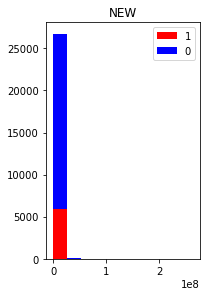

In [26]:
fig = plt.figure(figsize=(16, 5 * 4))
X = dataset.copy()
X['NEW'] = X['LIMIT_BAL'] * X['PAY_AMT_DEC']
#fields = ['DIOCANE', 'LIMIT_BAL', #1
#              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL', #6
#              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL' #6     
#         ]
fields = ['NEW']

# 13 fields
i = 1
for col_name in fields:
    ax = fig.add_subplot(4,5,i)
    i += 1
    # ax.set_ylabel('count')
    ax.set_title(col_name)
    
plt.show()

In [4]:
orig_dataset.head(5)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,BIRTH_DATE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,...,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
CUST_COD,,,,,,,,,,,,,,,,,,,,,
53613503,1490.680,M,university,single,NaN,0,0,0,0,2,...,629.156401,599.283174,608.257067,89.440800,149.06800,68.571280,0.000000,29.81360,59.627200,0
35524089,5664.584,M,university,married,04/01/1983,0,0,0,0,0,...,533.872135,-2.772665,-14.399969,149.068000,159.83071,29.813600,0.000000,0.00000,0.000000,1
58777007,6260.856,F,high school,married,02/01/1975,0,0,-1,-1,-2,...,-19.349026,-19.349026,-19.349026,59.627200,532.59015,16.963938,0.000000,0.00000,29.813600,0
26913418,8944.080,F,graduate school,married,15/01/1977,-2,-2,-2,-2,-2,...,88.546392,70.330282,253.177091,80.556347,217.22189,88.784901,70.628418,298.46395,216.416922,0
41993633,3577.632,F,graduate school,married,09/01/1978,-1,-1,-1,-1,-1,...,0.000000,569.439760,0.000000,119.254400,29.81360,0.000000,569.439760,0.00000,0.000000,1


In [5]:
orig_dataset.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,BILL_AMT_OCT,BILL_AMT_SEP,BILL_AMT_AUG,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,DEFAULT PAYMENT JAN
count,26884.00000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000,26884.000000
mean,4997.91411,-0.016367,-0.133313,-0.166344,-0.219052,-0.264879,-0.291884,1530.136656,1467.012379,1404.166272,1292.346498,1203.977907,1159.529034,168.639427,178.825861,156.416357,144.518815,144.259750,157.534344,0.221098
std,3879.73624,1.123991,1.197715,1.197837,1.171221,1.135089,1.150547,2206.111841,2129.923058,2072.220534,1923.241494,1816.137779,1775.876050,495.392694,688.001298,531.588567,465.903631,463.780141,538.637089,0.414994
min,298.13600,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-4936.535888,-2080.303567,-4688.605990,-2424.859342,-2424.859342,-10124.788000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1490.68000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,105.115300,87.622170,79.535231,68.951403,52.553923,37.594950,29.634718,24.879449,11.627304,8.884453,7.870790,3.637259,0.000000
50%,4173.90400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,667.198554,631.705464,599.491869,568.008707,539.998830,506.920641,62.608560,60.044590,54.260752,44.720400,44.720400,44.720400,0.000000
75%,7155.26400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1997.891324,1905.320095,1798.386166,1629.998953,1504.528417,1473.179417,149.276695,149.068000,134.369895,119.709057,120.379863,119.321481,0.000000
max,29813.60000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,28755.545150,29334.525260,49612.483810,26581.388370,27642.305330,28670.665830,26043.729910,50213.824120,26714.178140,18514.245600,12716.364990,15761.436660,1.000000


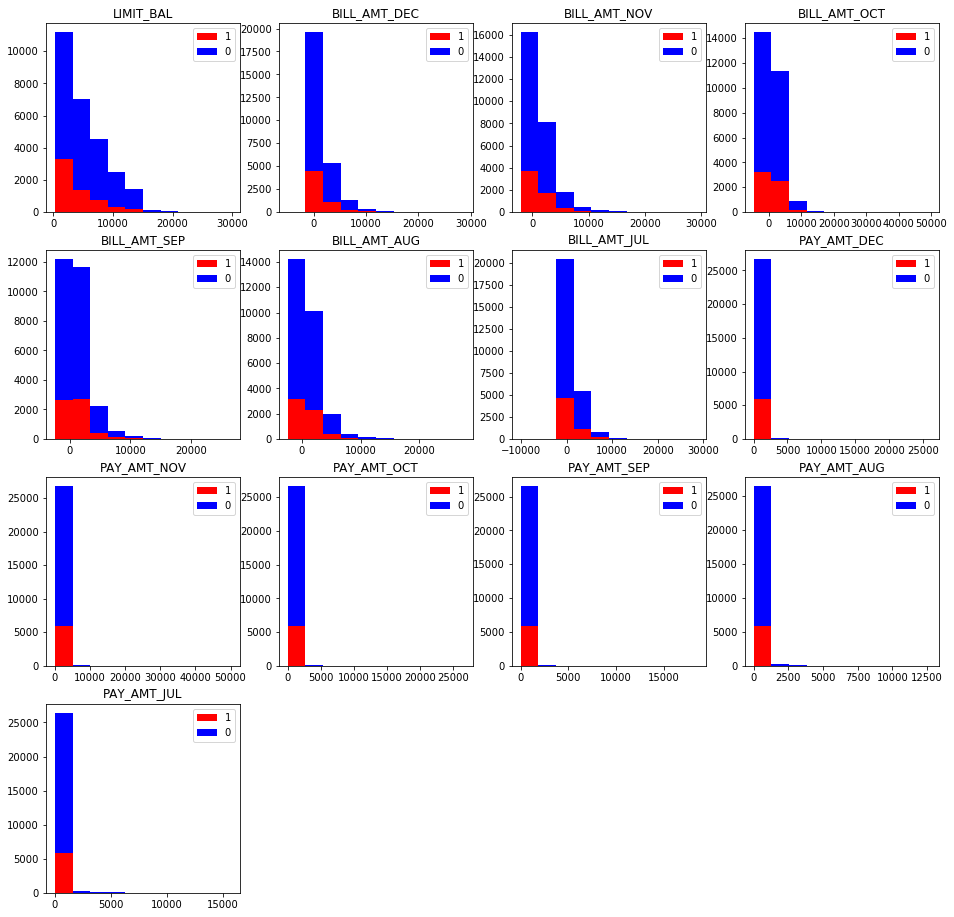

In [27]:
fig = plt.figure(figsize=(16, 4 * 4))
X = dataset.copy()
fields = ['LIMIT_BAL',
              'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
# 13 fields
i = 1
for col_name in fields:
    ax = fig.add_subplot(4,4,i)
    i += 1
    ax.set_title(col_name)
    ones = X[col_name][X['DEFAULT PAYMENT JAN'] == 1]
    zeros = X[col_name][X['DEFAULT PAYMENT JAN'] == 0]
    ax.hist((ones,zeros), histtype='barstacked', label=('1', '0'), color=('r', 'b'))
    ax.legend(loc='best')
    ax.hist(dataset[col_name][dataset['DEFAULT PAYMENT JAN'] == 0], 100, alpha=0.5, color='b')
    ax.hist(dataset[col_name][dataset['DEFAULT PAYMENT JAN'] == 1], 100, alpha=0.7, color='r')
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

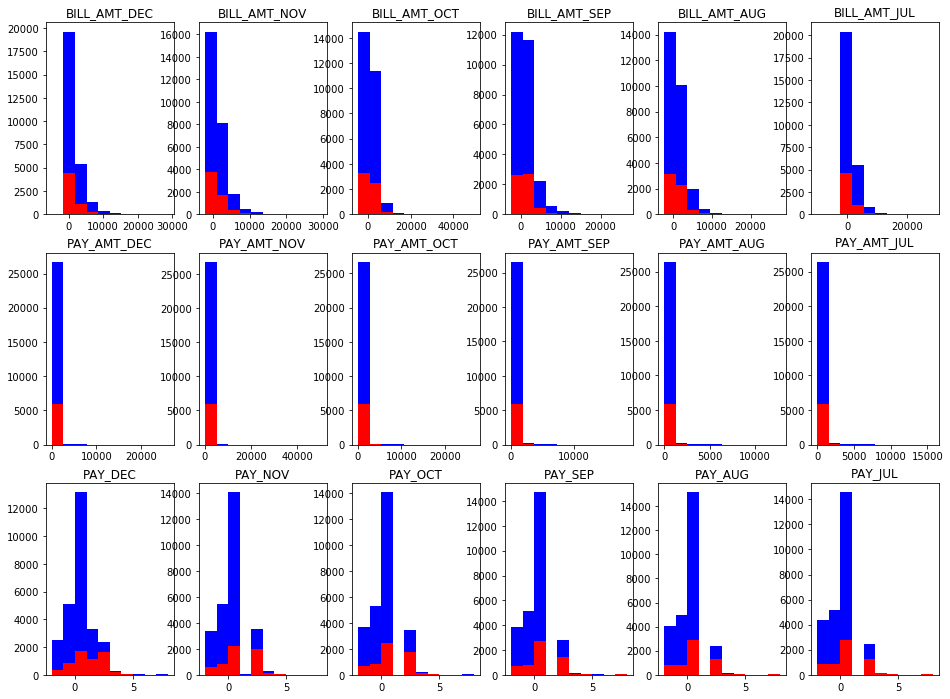

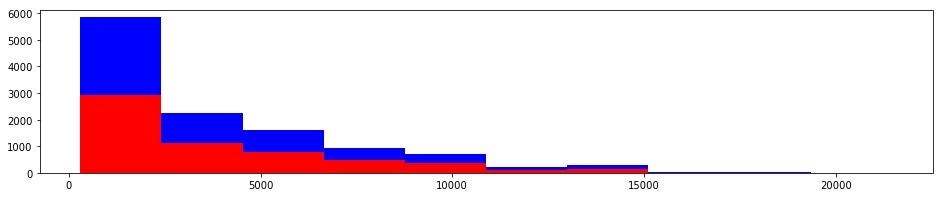

In [41]:
X = dataset

cols = [  'BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_DEC', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL',
             'PAY_DEC', 'PAY_NOV', 'PAY_OCT', 'PAY_SEP', 'PAY_AUG', 'PAY_JUL']
# 13 fields
i = 1

ones_mask = X['DEFAULT PAYMENT JAN'] == 1
zeros_mask = X['DEFAULT PAYMENT JAN'] == 0

fig = plt.figure(figsize=(16, 3 * 4))
for col in cols:
    ax = fig.add_subplot(3,6,i)
    i += 1
    ax.set_title(col)
    ones = X[col][ones_mask]
    zeros = X[col][zeros_mask]
    ax.hist((ones, zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
    #ax.legend(loc='best')
plt.show() 

plt.figure()
ones = X['LIMIT_BAL'][ones_mask]
zeros = X['LIMIT_BAL'][ones_mask]
plt.hist((ones,zeros), histtype='barstacked', bins=10, label=('1', '0'), color=('r', 'b'))
#plt.legend(loc='best')
plt.show() 

In [8]:
print((orig_dataset['PAY_AMT_DEC'] < 100).sum())
print((orig_dataset['PAY_AMT_NOV'] == 0).sum())
print((orig_dataset['PAY_AMT_OCT'] == 0).sum())
print((orig_dataset['PAY_AMT_SEP'] == 0).sum())
print((orig_dataset['PAY_AMT_AUG'] == 0).sum())
print((orig_dataset['PAY_AMT_JUL'] == 0).sum())
print()
k = 1
print(((orig_dataset['PAY_AMT_DEC'] < k) &
       (orig_dataset['PAY_AMT_NOV'] < k) &
       (orig_dataset['PAY_AMT_OCT'] < k) &
       (orig_dataset['PAY_AMT_SEP'] < k) &
       (orig_dataset['PAY_AMT_AUG'] < k) &
       (orig_dataset['PAY_AMT_JUL'] < k) &
       (orig_dataset['DEFAULT PAYMENT JAN'] == 0) ).sum())
print(((orig_dataset['PAY_AMT_DEC'] < k) &
       (orig_dataset['PAY_AMT_NOV'] < k) &
       (orig_dataset['PAY_AMT_OCT'] < k) &
       (orig_dataset['PAY_AMT_SEP'] < k) &
       (orig_dataset['PAY_AMT_AUG'] < k) &
       (orig_dataset['PAY_AMT_JUL'] < k) &
       (orig_dataset['DEFAULT PAYMENT JAN'] == 1) ).sum())

16997
4835
5334
5732
5989
6418

805
496


# Different datasets management
- split_and_add
- add_dataset
- retrieve_dataset

In [11]:
X_dict = {}
y_dict = {}
X_test_dict = {}
y_test_dict = {}
X_target_dict = {}

names = set()
target_col_name = 'DEFAULT PAYMENT JAN'

def split_and_add(name, dataset, target):
    train, test = train_test_split(dataset, test_size=0.33, random_state=r, stratify=dataset[target_col_name])
    X = train.drop([target_col_name], 1)
    y = train[target_col_name]
    X_test = test.drop([target_col_name], 1)
    y_test = test[target_col_name]
    add_dataset(name, X, y, X_test, y_test, target.drop(target_col_name, 1))
    print('Train X shape: {}'.format(X.shape))
    print('Test X shape: {}'.format(X_test.shape))
    print('Target X shape: {}'.format(X_target.shape))

def add_dataset(name, X, y, X_test, y_test, X_target):
    names.add(name)
    X_dict[name] = X
    y_dict[name] = y
    X_test_dict[name] = X_test
    y_test_dict[name] = y_test
    X_target_dict[name] = X_target

def retrieve_dataset(name):
    return (X_dict[name], y_dict[name], X_test_dict[name], y_test_dict[name], X_target_dict[name])

# split_and_add('orig', dataset, target)
split_and_add('orig', dataset, target)
non_numerical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'BIRTH_DATE']
split_and_add('baseline', dataset.drop(non_numerical_features, 1), target.drop(non_numerical_features, 1))
X, y, X_test, y_test, X_target = retrieve_dataset('baseline')
rs = RobustScaler()
rs.fit(X)
X = pd.DataFrame(rs.transform(X), index = X.index, columns = X.columns)
X_test = pd.DataFrame(rs.transform(X_test), index = X_test.index, columns = X_test.columns)
add_dataset('baseline_scaled', X, y, X_test, y_test, X_target)

Train X shape: (18012, 23)
Test X shape: (8872, 23)


NameError: name 'X_target' is not defined

# Alessandro's dataset
- One hot encoding of SEX
- scores to MARRIAGE and EDUCATION
- BIRTH_DATE transformed to AGE and normalized
- Columns with money values like LIMIT_BAL and BILL_AMT_DEC normalized togheter to mean=0 std=1
- Delay in payments normalized togheter to mean=0 std=1

In [19]:
def transform_features(X_orig):
    X = X_orig.copy()
    # print('One hot encoding SEX feature')
    # set(dataset["SEX"]) = {nan, 'M', 'F'}
    fields = {'SEX'}
    for field in fields:
        X = pd.concat([X.drop([field], 1), pd.get_dummies(X[field])], axis=1)

    # print('Scoring EDUCATION and MARRIAGE features')
    # Assume other == Nan
    # set(dataset["EDUCATION"]) = {nan, 'high school', 'graduate school', 'other§', 'university'}
    # set(dataset["MARRIAGE"]) = {nan, 'other', 'single', 'married'}
    education_dict = { 'other': 0, 'high school': 0.1, 'university': 0.5, 'graduate school': 1}
    marriage_dict = {'other': 0, 'single': 0.1, 'married': 1}
    X['EDUCATION'] = X['EDUCATION'].fillna('other').apply(lambda x: education_dict[x])
    X['MARRIAGE'] = X['MARRIAGE'].fillna('other').apply(lambda x: marriage_dict[x])

    #print('Computing AGE and dropping BIRTH_DATE')
    # Target: Year-Month-DayTTime
    X['BIRTH_DATE'] = pd.to_datetime(X['BIRTH_DATE'])
    
    def calculate_age(birth_date):
        today = date.today()
        age = today.year - birth_date.year
        full_year_passed = (today.month, today.day) < (birth_date.month, birth_date.day)
        if not full_year_passed:
            age -= 1
        return age
    X['AGE'] = X['BIRTH_DATE'].apply(lambda x: calculate_age(x))
    X = X.drop(["BIRTH_DATE"], 1)
    X['AGE'] = X['AGE'].fillna(X['AGE'].median())
    min_age = X['AGE'].min()
    max_age = X['AGE'].max()
    X['AGE'] = X['AGE'].apply(lambda x: (x - min_age) / (max_age - min_age))
    X['AGE'] = np.sqrt(X['AGE'])  

    # X['PA_DEC_-_BA_NOV'] = X['PAY_AMT_DEC'] - X['BILL_AMT_NOV']
    #X = X.drop(['BIRTH_DATE'], 1) 
    fields = ['BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL',
              'PAY_AMT_NOV', 'PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL']
    
    for field in fields:
        X[field] = X[field].apply(lambda x: -1 if x < 0 else 0 if x == 0 else 1)
    #X = X.drop(['BILL_AMT_DEC', 'BILL_AMT_NOV', 'BILL_AMT_OCT', 'BILL_AMT_SEP', 'BILL_AMT_AUG', 'BILL_AMT_JUL'], 1)
    #X = X.drop(['PAY_AMT_NOV', 'PAY_AMT_OCT', 'PAY_AMT_SEP', 'PAY_AMT_AUG', 'PAY_AMT_JUL'], 1)
    #X = X.drop(['M', 'F', 'EDUCATION', 'MARRIAGE', 'AGE'], 1)
    #X = X.drop(['M', 'F', 'EDUCATION', 'MARRIAGE'], 1)

    # print('Normalizing € fields')
    # X[fields] = X[fields].apply(lambda x: np.cbrt(x))
    # np.cbrt is the only one that works with negative numbers
    # using pow with 1/3 or 1/5 etc with negative numbers leads to complex number as results because of
    # numerical approximations
    # np.cbrt instead apply the direct algorithm to find cubic root, which is well defined for every negative numbe

    # print('Dataset prepared')
    # print(X.shape)
    
    return X.copy()

X, y, X_test, y_test, X_target = retrieve_dataset(name='orig')
X_ale = transform_features(X)
X_test_ale = transform_features(X_test)
X_target = transform_features(X_target)
add_dataset('ale', X_ale, y, X_test_ale, y_test, X_target)
X, y, X_test, y_test, X_target = retrieve_dataset(name='ale')
X.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,2385.088,0.5,0.1,1,2,2,2,2,-2,1,...,0,0.000000,1,1,0,0,0,1,0,0.360041
21308338,596.272,1.0,0.1,0,0,0,0,0,0,1,...,1,149.068000,1,1,1,1,1,1,0,0.192450
54049646,5366.448,0.1,1.0,0,0,0,0,0,0,1,...,1,116.034531,1,1,1,1,1,1,0,0.720082
10396398,894.408,0.1,0.1,-1,-1,-2,-2,-2,-2,1,...,0,0.000000,0,0,0,0,0,1,0,0.732828
11528589,3279.496,0.5,1.0,0,0,0,0,0,0,1,...,1,89.649495,1,1,1,1,1,0,1,0.593171


In [224]:
X.describe().round(3)

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PA_DEC_-_BA_NOV
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,4984.095,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,170.590,179.316,-1306.001
std,3853.542,1.122,1.191,1.195,1.176,1.143,1.158,486.272,621.159,2025.542
min,298.136,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,0.000,0.000,-21638.592
25%,1490.680,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,29.814,24.723,-1723.256
50%,4173.904,0.000,0.000,0.000,0.000,0.000,0.000,62.609,60.074,-509.350
75%,7155.264,0.000,0.000,0.000,0.000,0.000,0.000,149.187,149.068,0.000
max,22360.200,8.000,7.000,8.000,7.000,7.000,8.000,15055.868,36583.732,7165.550


In [20]:
X, y, X_test, y_test = retrieve_dataset(name='ale')
fields = ['LIMIT_BAL',
          'BILL_AMT_DEC', 'BILL_AMT_NOV',
          'PAY_AMT_DEC', 'PAY_AMT_NOV']
for col_name in fields:
    fig, axarr = plt.subplots(1, 2, figsize=(16, 3))
    axarr[0].hist(orig_dataset[col_name], 100, facecolor='b')
    # axarr[0].set_xlabel('Value')
    # axarr[0].set_ylabel('Density')
    axarr[0].set_title('orig_dataset[{}]'.format(col_name))

    axarr[1].hist(X[col_name], 100, facecolor='y')
    # axarr[1].set_xlabel('Value')
    # axarr[1].set_ylabel('Density')
    axarr[1].set_title('ale[{}]'.format(col_name))

    plt.show()

ValueError: too many values to unpack (expected 4)

In [119]:
X.describe()

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,BILL_AMT_NOV,PAY_AMT_DEC,PAY_AMT_NOV,LB_-_PANOV,LB_-_PADEC
count,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000,18012.000000
mean,15.837318,-0.009272,-0.129192,-0.161837,-0.211470,-0.255663,-0.284977,8.934725,8.692085,4.041718,4.000230,15.566588,15.571764
std,4.609824,1.121547,1.191469,1.195443,1.176348,1.143224,1.157763,5.484973,5.538096,2.693064,2.769049,4.759589,4.758717
min,6.680436,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-17.027103,-12.765630,0.000000,0.000000,-27.754138,-18.283364
25%,11.423385,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.830134,4.490168,3.100784,2.913175,11.423385,11.423385
50%,16.100801,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.856074,8.691676,3.970799,3.916485,15.906797,15.895005
75%,19.269712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.645696,12.446715,5.303679,5.302266,18.998271,18.998271
max,28.172490,8.000000,7.000000,8.000000,7.000000,7.000000,8.000000,28.132541,28.096784,24.692701,33.196783,28.143285,28.086873


# Dataset Creation - ale_scaled

In [21]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale')
rs = RobustScaler()
rs.fit(X)
X_scaled = pd.DataFrame(rs.transform(X), columns=X.columns, index=X.index)
X_test_scaled = pd.DataFrame(rs.transform(X_test), columns=X_test.columns, index=X_test.index)
X_target_scaled = pd.DataFrame(rs.transform(X_target), columns=X_target.columns, index=X_target.index)
add_dataset('ale_scaled', X_scaled, y, X_test_scaled, y_test, X_target_scaled)
X_scaled.head(5)

,LIMIT_BAL,EDUCATION,MARRIAGE,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,BILL_AMT_DEC,...,BILL_AMT_JUL,PAY_AMT_DEC,PAY_AMT_NOV,PAY_AMT_OCT,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,F,M,AGE
CUST_COD,,,,,,,,,,,,,,,,,,,,,
14356766,-0.315789,0.0,0.0,1.0,2.0,2.0,2.0,2.0,-2.0,0.0,...,-1.0,-0.524476,0.0,0.0,-1.0,-1.0,-1.0,0.0,0.0,-0.583923
21308338,-0.631579,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.724276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.333167
54049646,0.210526,-0.8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.447552,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.025700
10396398,-0.578947,-0.8,0.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,0.0,...,-1.0,-0.524476,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1.082682
11528589,-0.157895,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.226523,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.458322


In [280]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')
pd.concat([X, y], axis=1).to_csv('train.csv', index=False)
pd.concat([X_test, y_test], axis=1).to_csv('test.csv', index=False)

In [255]:
X_scaled.describe().round(3)

,LIMIT_BAL,PAY_DEC,PAY_NOV,PAY_OCT,PAY_SEP,PAY_AUG,PAY_JUL,PAY_AMT_DEC
count,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000,18012.000
mean,0.143,-0.009,-0.129,-0.162,-0.211,-0.256,-0.285,0.905
std,0.680,1.122,1.191,1.195,1.176,1.143,1.158,4.074
min,-0.684,-2.000,-2.000,-2.000,-2.000,-2.000,-2.000,-0.524
25%,-0.474,-1.000,-1.000,-1.000,-1.000,-1.000,-1.000,-0.275
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.526,0.000,0.000,0.000,0.000,0.000,0.000,0.725
max,3.211,8.000,7.000,8.000,7.000,7.000,8.000,125.599


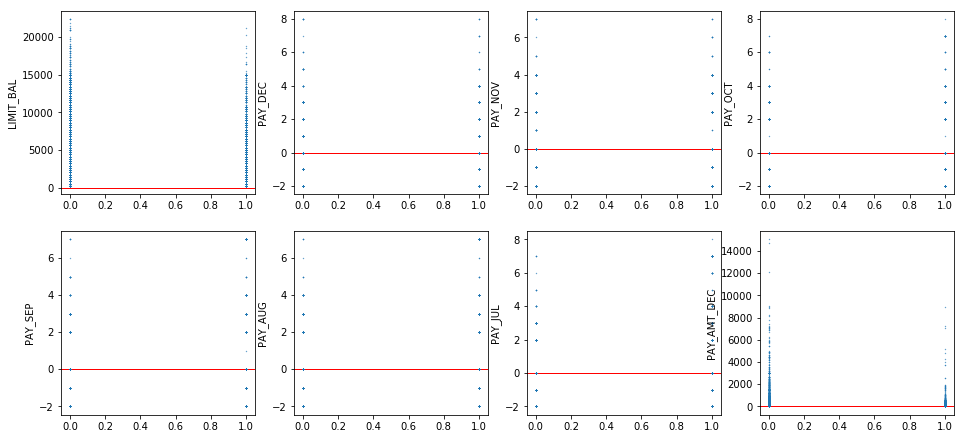

In [256]:
X, y, X_test, y_test = retrieve_dataset('ale')

i = 1
fig = plt.figure(figsize=(16, 12 * 4))
for col_name in X.columns:
    ax = fig.add_subplot(12, 4, i)
    i += 1
    ax.set_ylabel(col_name)
    ax.scatter(y, X[col_name], s=0.1)
    ax.axhline(y=0, c='red', linewidth=1, zorder=0)
plt.show() 

In [22]:
X, y, X_test, y_test = retrieve_dataset('ale')
fig = plt.figure(figsize=(15, 12 * 4))
i = 1
for col_name in X.columns:
    ax = fig.add_subplot(12, 4, i)
    i += 1
    ax.set_title('ale[{}]'.format(col_name))
    ax.hist(X[col_name], 100, normed=1)
plt.show()

ValueError: too many values to unpack (expected 4)

# Preliminary Prediction Tests

In [258]:
X, y, X_test, y_test = retrieve_dataset(name='orig')

y_pred = X['PAY_AMT_DEC'] < X['BILL_AMT_DEC']
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_AMT_DEC'] < X['BILL_AMT_DEC'] + 1000)
y_pred &= (X['PAY_AMT_NOV'] < X['BILL_AMT_NOV'] + 1000)
y_pred &= (X['PAY_AMT_OCT'] < X['BILL_AMT_OCT'] + 1000)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

y_pred = (X['PAY_DEC'] > 0)
y_pred &= (X['PAY_NOV'] > 0)
y_pred &= (X['PAY_OCT'] > 0)
print(confusion_matrix(y, y_pred))
print(f1_score(y, y_pred))

[[ 3109 10921]
 [  735  3247]]
0.357796143251
[[11985  2045]
 [ 1913  2069]]
0.511116600791
[[12057  1973]
 [ 1934  2048]]
0.511808071973
[[13432   598]
 [ 2931  1051]]
0.373290712129


# PAY_AMT vs Month, BILL_AMT vs Month

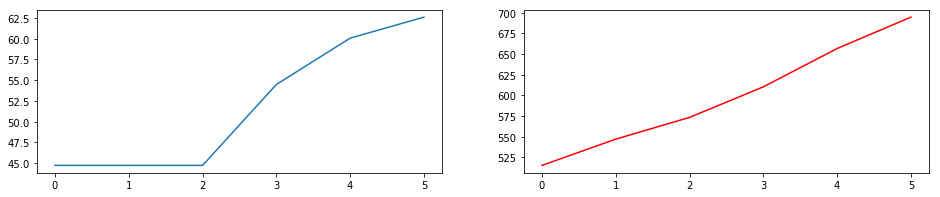

In [259]:
X, y, X_test, y_test = retrieve_dataset(name='orig')
months = ['JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']

m = [X['PAY_AMT_{}'.format(month)].median() for month in months]

fig = plt.figure(figsize=(16, 3))
ax = fig.add_subplot(1, 2, 1)
ax.plot(m)
m = [X['BILL_AMT_{}'.format(month)].median() for month in months]
ax = fig.add_subplot(1, 2, 2)
ax.plot(m, c='r')

plt.show()


In [89]:
import sys, math
 
def rotateX(self, angle):
    """ Rotates the point around the X axis by the given angle in degrees. """
    rad = angle * math.pi / 180
    cosa = math.cos(rad)
    sina = math.sin(rad)
    y = self.y * cosa - self.z * sina
    z = self.y * sina + self.z * cosa
    return np.array(self.x, y, z)
 
def rotateY(self, angle):
    """ Rotates the point around the Y axis by the given angle in degrees. """
    rad = angle * math.pi / 180
    cosa = math.cos(rad)
    sina = math.sin(rad)
    z = self.z * cosa - self.x * sina
    x = self.z * sina + self.x * cosa
    return np.array(x, self.y, z)
 
def rotateZ(self, angle):
    """ Rotates the point around the Z axis by the given angle in degrees. """
        rad = angle * math.pi / 180
        cosa = math.cos(rad)
        sina = math.sin(rad)
        x = self.x * cosa - self.y * sina
        y = self.x * sina + self.y * cosa
        return np.array(x, y, self.z)
 
    def project(self, win_width, win_height, fov, viewer_distance):
        """ Transforms this 3D point to 2D using a perspective projection. """
        factor = fov / (viewer_distance + self.z)
        x = self.x * factor + win_width / 2
        y = -self.y * factor + win_height / 2
        return np.array(x, y, 1)   

# Variables distribution

# 2D PCA - ale_scaled

NameError: name 'df' is not defined

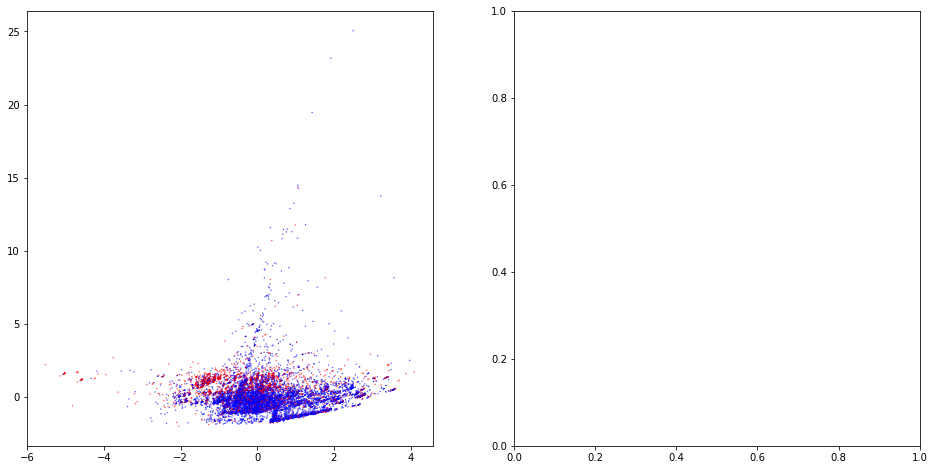

In [23]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')

colors = {0: 'b', 1: 'r'}
sizes = {0: 0.1, 1: 0.1}

def color(y):
    return pd.Series(y).apply(lambda x: colors[x])
def size(y):
    return pd.Series(y).apply(lambda x: sizes[x])

pca = PCA(whiten=True, random_state=r, n_components=3)
pca.fit(X)

from numpy import cross, eye, dot
from scipy.linalg import expm, norm
def M(axis, theta):
    return expm(cross(eye(3), axis / norm(axis) * theta))

axis, theta = [0,1,1], 3.14 * 0.5
M0 = M(axis, theta)

# print(dot(M0,[1,0,0]))
points = []





X_tf = pd.DataFrame(pca.transform(X)).apply(lambda x: dot(M0, x), axis=1).drop([2], axis=1)
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
ax.scatter(X_tf[0], X_tf[1], c=color(y), s=size(y))

X_target_tf = pd.DataFrame(pca.transform(X_target)).apply(lambda x: dot(M0, x), axis=1).drop([2], axis=1)
clf = LogisticRegression()
clf.fit(X_tf, y)
y_pred = clf.predict(X_target_tf)

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df[0], df[1], c=color(y_pred), s=size(y_pred))
plt.show()

# 3D PCA - ale_scaled

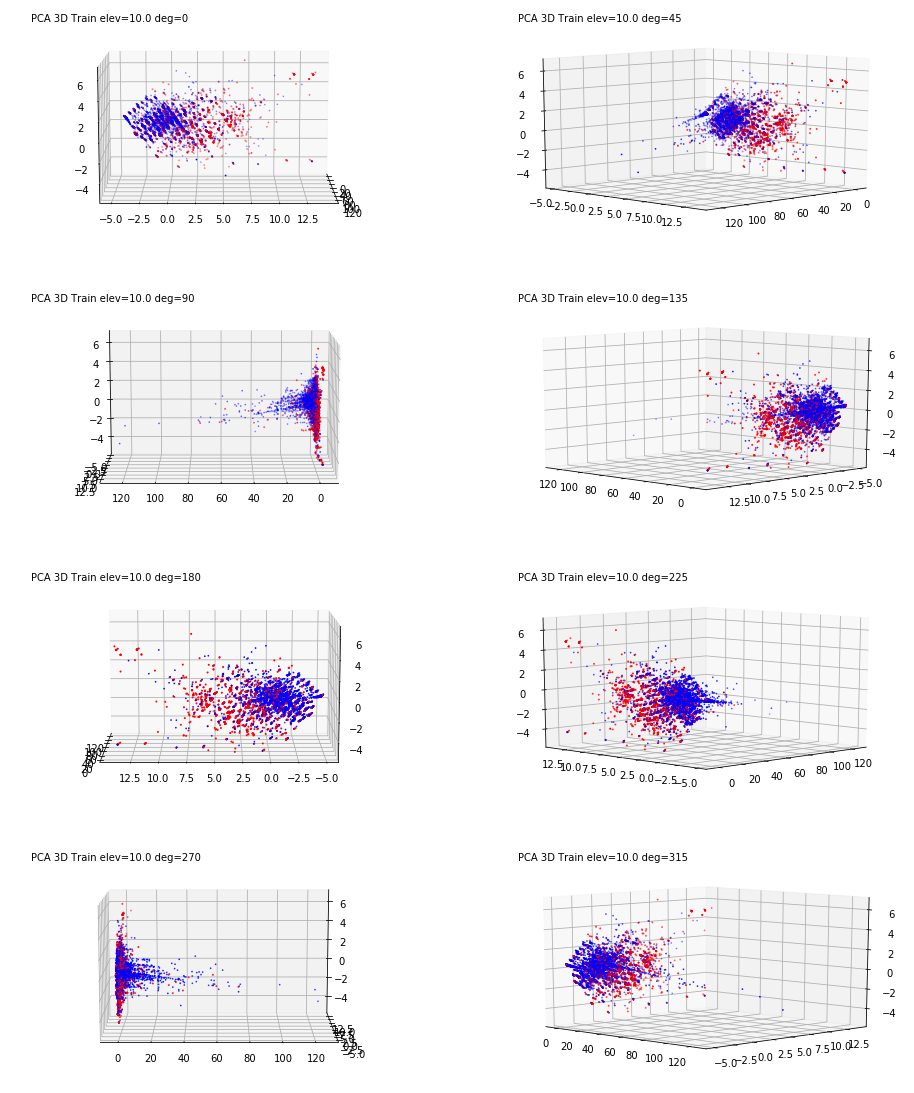

ValueError: Shape of passed values is (3, 3116), indices imply (3, 18012)

In [44]:
X, y, X_test, y_test, X_target = retrieve_dataset('ale_scaled')
colors = {0: 'b', 1: 'r', 2: 'y'}
sizes = {0: 0.5, 1: 1}
c = y.apply(lambda x: colors[x])
s = y.apply(lambda x: sizes[x])

pca = PCA(whiten=False, random_state=r, n_components=3)
pca.fit(pd.concat([X, X_test]))
df = pd.DataFrame(pca.transform(X), index=X.index)
# kmeans = KMeans(n_clusters=5, random_state=r, copy_x=True, n_jobs=-1).fit(df)
# c = list(map(lambda x: 'C{}'.format(x), list(kmeans.predict(df))))
fig = plt.figure(figsize=(16, 6 * 5))
for ii in np.arange(0, 360, 45):
    ax = fig.add_subplot(6, 2, ii / 45 + 1, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=c, s=s)
plt.show()

df = pd.DataFrame(pca.transform(X_target), index=X.index)
# kmeans = KMeans(n_clusters=5, random_state=r, copy_x=True, n_jobs=-1).fit(df)
# c = list(map(lambda x: 'C{}'.format(x), list(kmeans.predict(df))))
fig = plt.figure(figsize=(16, 6 * 5))
for ii in np.arange(0, 360, 45):
    ax = fig.add_subplot(6, 2, ii / 45 + 1, projection='3d')
    ax.text2D(0.05, 0.95, 'PCA 3D Train elev={} deg={}'.format(10., ii), transform=ax.transAxes)
    ax.view_init(elev=10., azim=ii)
    ax.scatter(df[0], df[1], df[2], c=c, s=s)
plt.show()

# PCA - tresh = 0.95

Starting PCA
cumsum_tresh = 0.8, n_components = 1
cumsum_tresh = 0.85, n_components = 1
cumsum_tresh = 0.9, n_components = 2
cumsum_tresh = 0.95, n_components = 3
cumsum_tresh = 0.97, n_components = 5
cumsum_tresh = 0.99, n_components = 6


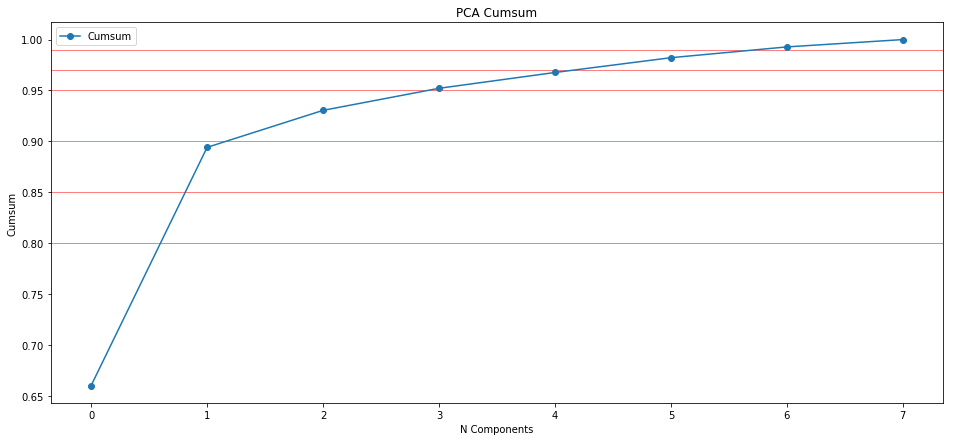

Selecting tresh = 0.95 -> n_components = 3


In [262]:
X, y, X_test, y_test = retrieve_dataset('ale_scaled')

print('Starting PCA')
pca = PCA(whiten=False, random_state=r)
pca.fit(X)

cumsum = sorted(list(pca.explained_variance_ratio_.cumsum()))

def find_cumsum_tresh(cumsum, cumsum_tresh):
    for i in np.arange(0, len(cumsum)):
        if cumsum[i] >= cumsum_tresh:
            break
    return i

plt.figure(figsize=(16, 7))
plt.plot(cumsum, label='Cumsum', marker='o')
plt.xlabel('N Components')
plt.ylabel('Cumsum')
plt.title('PCA Cumsum')
plt.legend(loc='best')

for i in [0.8, 0.85, 0.9, 0.95, 0.97, 0.99]:
    n_components = find_cumsum_tresh(cumsum, i)
    print('cumsum_tresh = {}, n_components = {}'.format(i, n_components))
    plt.axhline(y=i, c='red', linewidth=0.5, zorder=0)

plt.show()

tresh = 0.95

n_components = find_cumsum_tresh(cumsum, tresh)
print('Selecting tresh = {} -> n_components = {}'.format(tresh, n_components))
pca = PCA(whiten=False, random_state=r, n_components=n_components)
pca.fit(X)
X_pca = pd.DataFrame(pca.transform(X), index=X.index)
X_pca_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)

add_dataset(X_pca, y, X_pca_test, y_test, 'ale_pca')

In [264]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
X.head(5)

,0,1,2
CUST_COD,,,
14356766,-1.556543,3.370673,-1.190284
21308338,-0.215404,0.505435,0.138353
54049646,-0.461892,0.417585,0.215486
10396398,-1.370017,-3.649759,-0.691212
11528589,-0.695656,0.445227,0.191157


In [265]:
X.describe().round(3)

,0,1,2
count,18012.000,18012.000,18012.000
mean,-0.000,0.000,0.000
std,4.079,2.428,0.957
min,-1.957,-4.693,-5.063
25%,-1.190,-1.606,-0.301
50%,-0.906,0.409,0.184
75%,-0.158,0.576,0.369
max,124.527,13.898,6.342


# CV and scoring functions

In [30]:
def score_matrix(y, y_pred):
    cm = confusion_matrix(y, y_pred)
    # first index true
    # second index predicted
    return cm[0][0] * 1 + cm[0][1] * 0 + cm[1][0] * 0 + cm[1][1] * 4

def cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test):
    scores_stkfold = cross_val_score(clf, X, y, scoring='f1', cv=cv)
    f1_cv_mean = scores_stkfold.mean()
    f1_cv_std = scores_stkfold.std()
    f1_train = f1_score(y, y_pred)  
    f1_test = f1_score(y_test, y_pred_test)
    print('f1_train = {:.3f}\t f1_cv = {:.3f} ± {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_cv_mean, f1_cv_std, f1_test))
    # cost_train = cost_matrix(y, y_pred)
    # cost_test = cost_matrix(y_test, y_pred_test)
    # print('cost_train = {}\ncost_test = {}'.format(format(cost_train, ','), format(cost_test, ',')))
    cm_train = confusion_matrix(y, y_pred)
    cm_test = confusion_matrix(y_test, y_pred_test)
    print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

def fit_and_score(clf, name):
    print('Evaluating on ' + name + ' dataset')
    X, y, X_test, y_test, _ = retrieve_dataset(name)
    clf.fit(X, y)
    y_pred = clf.predict(X)
    y_pred_test = clf.predict(X_test)
    cv_clf(clf, X, y, y_pred, X_test, y_test, y_pred_test)
    if (hasattr(clf, 'predict_proba')):
        return (pd.DataFrame(clf.predict_proba(X), index = X.index)[1], 
                pd.DataFrame(clf.predict_proba(X_test), index = X_test.index)[1])
    else:
        return (y_pred, y_pred_test)

cv = StratifiedKFold(n_splits=10, random_state=r, shuffle=True)    
ms = make_scorer(score_matrix, greater_is_better=True)

# ROC curve function

In [31]:
def plot_roc_curve(clf, X_test, y_test):
    y_score = clf.decision_function(X_test)
    # Compute ROC curve and ROC area for each class
    fpr, tpr, t = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    t_sigm = 1 / (1 + np.exp(-t))

    i = sum(t < 0.5 for t in t_sigm)
    
    plt.figure(figsize=(16,7))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr[i], tpr[i], 'ro')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Grid Search CV function

In [33]:
def grid_search_cv(parameters, clf, n_folds=10, dataset_name='baseline', scoring='f1'):
    cv=StratifiedKFold(n_splits=n_folds, random_state=r, shuffle=True)
    n_jobs = -1
    if scoring == ms:
        n_jobs = 1
    gscv = GridSearchCV(estimator=clf, param_grid=parameters, n_jobs=n_jobs, cv=cv, scoring=scoring)
    X, y, X_test, y_test, _ = retrieve_dataset(dataset_name)
    gscv.fit(X, y)
    print('GridSearchCV done on: ' + dataset_name)
    print(gscv.best_params_)
    if scoring == ms:
            scoring = 'score'
    print(scoring + ' = ' + str(gscv.best_score_))
    if len(parameters) == 1:
        plt.figure(1)
        param_name = list(parameters.keys())[0]
        if param_name == 'C':
            plt.semilogx(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        else:
            plt.plot(parameters[param_name], gscv.cv_results_['mean_test_score'], label=scoring, marker='o')
        plt.xlabel(param_name)
        plt.ylabel(scoring)
        plt.title('CV ' + scoring)
        plt.legend(loc='best')
        plt.show()

# Level 1 algorithms - Learning from features

In [269]:
X, y, X_test, y_test, X_target = retrieve_dataset('orig')
X_meta = pd.DataFrame(index=X.index)
X_meta_test = pd.DataFrame(index=X_test.index)

# Level 1 - Dummy Classifier
- All datasets: f1_cv = 0.217 ± 0.018

In [270]:
clf = DummyClassifier(random_state=r)
y_pred, y_pred_test = fit_and_score(clf, 'baseline')

Evaluating on baseline dataset
f1_train = 0.221	 f1_cv = 0.217 ± 0.018
f1_test = 0.225
cm_train = 
[[10932  3098]
 [ 3104   878]]
cm_test = 
[[5369 1541]
 [1519  443]]


# Level 1 - Linear Support Vector Classifier
- baseline: f1_cv = 0.522 ± 0.023

In [34]:
clf = LinearSVC(penalty='l2',
                loss='squared_hinge',
                dual=False,
                tol=1e-4,
                C=1,
                fit_intercept=True,
                intercept_scaling=1.0,
                class_weight='balanced',
                verbose=1000,
                random_state=r,
                max_iter=1000
               )
y_pred, y_pred_test = fit_and_score(clf, 'ale')
X_meta['LSVC_baseline'] = y_pred
X_meta_test['LSVC_baseline'] = y_pred_test

Evaluating on ale dataset
[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]f1_train = 0.510	 f1_cv = 0.509 ± 0.020
f1_test = 0.510
cm_train = 
[[10911  3119]
 [ 1554  2428]]
cm_test = 
[[5385 1525]
 [ 769 1193]]


NameError: name 'X_meta' is not defined

# Level 1 - TOO SLOW, OVERFITS Level 2 - Support Vector Classifier
- ale_pca: f1_cv = 0.351 ± 0.026

In [278]:
if True:
    clf = SVC(random_state=r, C=1, class_weight='balanced')
    y_pred, y_pred_test = fit_and_score(clf, 'ale_pca')
    X_meta['SVC_ale_pca'] = y_pred
    X_meta_test['SVC_ale_pca'] = y_pred_test

Evaluating on ale_pca dataset
f1_train = 0.539	 f1_cv = 0.531 ± 0.020
f1_test = 0.527
cm_train = 
[[11949  2081]
 [ 1746  2236]]
cm_test = 
[[5877 1033]
 [ 891 1071]]


# Level 1 - Decision Tree Classifier
- baseline: f1_cv = 0.533 ± 0.021

In [239]:
clf = DecisionTreeClassifier(random_state=r, max_depth=4, class_weight='balanced')
# grid_search_cv(parameters={'max_depth': np.arange(1,10)}, clf=clf, scoring='f1', dataset_name='baseline')
y_pred, y_pred_test = fit_and_score(clf, 'ale')
X_meta['DTC_baseline'] = y_pred
X_meta_test['DTC_baseline'] = y_pred_test

Evaluating on ale dataset
f1_train = 0.541	 f1_cv = 0.534 ± 0.019
f1_test = 0.528
cm_train = 
[[12033  1997]
 [ 1765  2217]]
cm_test = 
[[5917  993]
 [ 901 1061]]


# Level 1 - Gaussian Naive Bayes
- baseline: f1_cv = 0.521 ± 0.014

In [35]:
# No random_state
# The priors are set based on class distribution in the dataset
# No CV needed
clf = GaussianNB()
y_meta, y_meta_test = fit_and_score(clf, 'baseline')
X_meta['GNB_baseline'] = y_meta
X_meta_test['GNB_baseline'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.490	 f1_cv = 0.489 ± 0.022
f1_test = 0.480
cm_train = 
[[11828  2202]
 [ 1977  2005]]
cm_test = 
[[5818 1092]
 [ 997  965]]


NameError: name 'X_meta' is not defined

# Level 1 - Random Forest Classifier
- baseline: f1_cv = 0.533 ± 0.026
- ale: f1_cv = 0.539 ± 0.022

In [39]:
clf = RandomForestClassifier(random_state=r,
                             n_estimators=500,
                             class_weight=None,
                             #max_depth=3,
                             n_jobs=-1,
                             #bootstrap=True
                            )
# TOO SLOW
# grid_search_cv(parameters={'n_estimators': [100, 250, 500, 1000, 2000]}, n_folds=3, clf=clf, scoring='f1', dataset_name='ale')
y_meta, y_meta_pred = fit_and_score(clf, 'ale')
X_meta['RFC_baseline'] = y_meta
X_meta_test['RFC_baseline'] = y_meta_pred

Evaluating on ale dataset
f1_train = 0.996	 f1_cv = 0.470 ± 0.022
f1_test = 0.456
cm_train = 
[[14022     8]
 [   26  3956]]
cm_test = 
[[6472  438]
 [1254  708]]


NameError: name 'X_meta' is not defined

Feature ranking:
1. feature PAY_AMT_DEC (0.175336)
2. feature AGE (0.170159)
3. feature LIMIT_BAL (0.147243)
4. feature PAY_DEC (0.112261)
5. feature PAY_NOV (0.052114)
6. feature EDUCATION (0.044441)
7. feature PAY_OCT (0.037680)
8. feature PAY_SEP (0.033160)
9. feature PAY_AUG (0.032554)
10. feature PAY_JUL (0.032460)
11. feature MARRIAGE (0.029385)
12. feature PAY_AMT_JUL (0.017890)
13. feature F (0.014999)
14. feature M (0.014965)
15. feature PAY_AMT_AUG (0.012380)
16. feature PAY_AMT_OCT (0.012028)
17. feature PAY_AMT_SEP (0.011470)
18. feature PAY_AMT_NOV (0.010118)
19. feature BILL_AMT_JUL (0.009335)
20. feature BILL_AMT_AUG (0.006718)
21. feature BILL_AMT_DEC (0.006514)
22. feature BILL_AMT_SEP (0.005693)
23. feature BILL_AMT_OCT (0.005666)
24. feature BILL_AMT_NOV (0.005432)


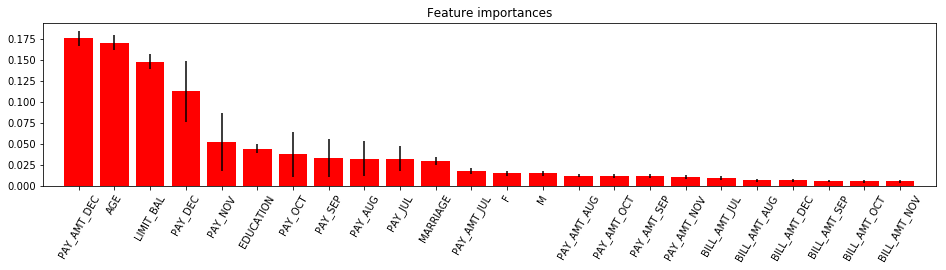

In [40]:
X, y, X_test, y_test, _ = retrieve_dataset('ale')
forest = clf
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# Level 1 - OVERFITS Level 2 - K Neighbors Classifier
- baseline_scaled: f1_cv = 0.442 ± 0.024

In [158]:
if False:
    clf = KNeighborsClassifier(n_neighbors=5,
                           weights='uniform',
                           algorithm='auto',
                           leaf_size=30,
                           p=2,
                           metric='minkowski',
                           metric_params=None,
                           n_jobs=-1
                          )
    #grid_search_cv(parameters={'n_neighbors': np.arange(1,5), 'algorithm': ['ball_tree', 'kd_tree']}, clf=clf, scoring='f1', dataset_name='ale_pca')
    y_meta, y_meta_test = fit_and_score(clf, 'baseline_scaled')
    X_meta['KNNC_baseline_scaled'] = y_meta
    X_meta_test['KNNC_baseline_scaled'] = y_meta_test

# Level 1 - Multi Layer Perceptron Classifier
- ale: f1_cv = 0.525 ± 0.025 (24,12,8,4,2)

In [52]:
clf = MLPClassifier(hidden_layer_sizes=(24,12,8,4,2),
                    solver='adam',
                    activation='logistic',
                    batch_size=500,
                    # validation_fraction=0.5,
                    random_state=r,
                    verbose=False
                   )
y_meta, y_meta_test = fit_and_score(clf, 'ale')
X_meta['MLPC_baseline_scaled'] = y_meta
X_meta_test['MLPC_baseline_scaled'] = y_meta_test

Evaluating on ale dataset


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classifi

f1_train = 0.000	 f1_cv = 0.000 ± 0.000
f1_test = 0.000
cm_train = 
[[14030     0]
 [ 3982     0]]
cm_test = 
[[6910    0]
 [1962    0]]


C:\Users\Alessandro\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


NameError: name 'X_meta' is not defined

# Level 1 - Logistic Regression
- ale_pca: f1_cv = 0.511 ± 0.018

In [43]:
clf = LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
# grid_search_cv(parameters={'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}, clf=clf, scoring='f1', dataset_name='ale_pca')
y_meta, y_meta_test = fit_and_score(clf, 'ale')
X_meta['LR_ale_pca'] = y_meta
X_meta_test['LR_ale_pca'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.508	 f1_cv = 0.509 ± 0.019
f1_test = 0.511
cm_train = 
[[10813  3217]
 [ 1534  2448]]
cm_test = 
[[5368 1542]
 [ 759 1203]]


NameError: name 'X_meta' is not defined

In [44]:
X, y, X_test, y_test = retrieve_dataset('ale_pca')
clf.fit(X, y)
print(clf.coef_)
plot_roc_curve(clf, X, y)
# plot_roc_curve(clf, X_test, y_test)
# t = 0.53
# y_pred = pd.DataFrame(clf.predict_proba(X))[1] > t # p0 p1
# y_pred_test = pd.DataFrame(clf.predict_proba(X_test))[1] > t # p0 p1
# f1_train = f1_score(y, y_pred)  
# f1_test = f1_score(y_test, y_pred_test)
# print('f1_train = {:.3f}\nf1_test = {:.3f}'.format(f1_train, f1_test))
# cm_train = confusion_matrix(y, y_pred)
# cm_test = confusion_matrix(y_test, y_pred_test)
# print('cm_train = \n{}\ncm_test = \n{}'.format(cm_train, cm_test))

KeyError: 'ale_pca'

# Level 1 - XGBClassifier
- ale: f1_cv = 0.548 ± 0.021

In [47]:
# clf = XGBClassifier(seed=r, scale_pos_weight=3,
#                     learning_rate=0.1, n_estimators=100, 
#                     max_depth=3, min_child_weight=1,
#                     gamma=0.2, colsample_bytree=0.8, subsample=0.6)
clf = XGBClassifier(seed=r,
                    scale_pos_weight=3,
                    learning_rate=0.1
                   )
# grid_search_cv(parameters={'colsample_bytree':[0.2,0.5,0.8]}, clf=clf, scoring='f1', dataset_name='baseline')
y_meta, y_meta_test = fit_and_score(clf, 'ale')

X_meta['XGB_ale'] = y_meta
X_meta_test['XGB_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.560	 f1_cv = 0.547 ± 0.026
f1_test = 0.544
cm_train = 
[[11895  2135]
 [ 1603  2379]]
cm_test = 
[[5826 1084]
 [ 823 1139]]


NameError: name 'X_meta' is not defined

Feature ranking:
1. feature PAY_AMT_DEC (0.223859)
2. feature LIMIT_BAL (0.144330)
3. feature PAY_DEC (0.116348)
4. feature AGE (0.095729)
5. feature PAY_JUL (0.053019)
6. feature EDUCATION (0.051546)
7. feature PAY_OCT (0.042710)
8. feature PAY_NOV (0.038292)
9. feature MARRIAGE (0.033873)
10. feature PAY_SEP (0.023564)
11. feature PAY_AMT_OCT (0.023564)
12. feature BILL_AMT_DEC (0.022091)
13. feature M (0.022091)
14. feature PAY_AMT_SEP (0.019146)
15. feature PAY_AUG (0.019146)
16. feature PAY_AMT_JUL (0.014728)
17. feature BILL_AMT_SEP (0.013255)
18. feature PAY_AMT_AUG (0.011782)
19. feature BILL_AMT_NOV (0.005891)
20. feature BILL_AMT_AUG (0.005891)
21. feature BILL_AMT_JUL (0.005891)
22. feature PAY_AMT_NOV (0.005891)
23. feature BILL_AMT_OCT (0.004418)
24. feature F (0.002946)


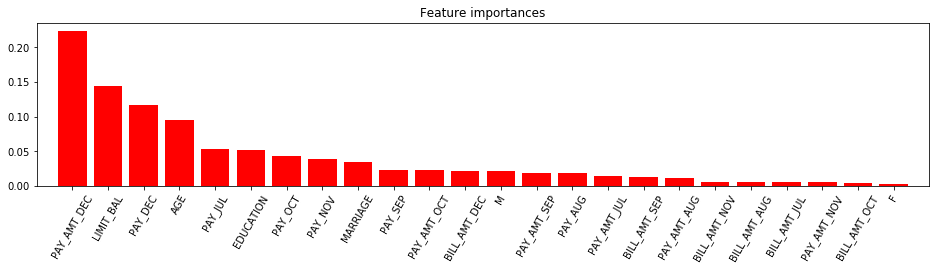

In [49]:
X, y, X_test, y_test, _ = retrieve_dataset('ale')
forest = clf
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
l_cols = list(X.columns)
labels = [X.columns[i] for i in indices]

# Print the feature ranking
print("Feature ranking:")
for f in np.arange(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, labels[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(np.arange(X.shape[1]), importances[indices], color="r", align="center")
plt.xticks(np.arange(X.shape[1]), labels, rotation=60)
plt.xlim([-1, X.shape[1]])
plt.show()

# Level 1 - MEMORY ERROR, Gaussian Process Classifier

In [194]:
if False:
    clf = GaussianProcessClassifier(kernel=None,
                                optimizer='fmin_l_bfgs_b',
                                n_restarts_optimizer=0, 
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=r,
                                #multi_class='one_vs_rest',
                                n_jobs=-1)
    y_meta, y_meta_test = fit_and_score(clf, 'baseline')
    X_meta['GPC_baseline'] = y_meta
    X_meta_test['GPC_baseline'] = y_meta_test

# Level 1 - Linear Discriminant Analysis

In [50]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis(solver='svd', shrinkage=None, priors=[0.5, 0.5], 
                                 n_components=None, store_covariance=False, tol=0.0001)
y_meta, y_meta_test = fit_and_score(clf, 'ale')
X_meta['LDA_ale'] = y_meta
X_meta_test['LDA_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.515	 f1_cv = 0.513 ± 0.019
f1_test = 0.516
cm_train = 
[[11104  2926]
 [ 1586  2396]]
cm_test = 
[[5479 1431]
 [ 781 1181]]


NameError: name 'X_meta' is not defined

# Level 1 - Quadratic Discriminant Analysis

In [51]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clf = QuadraticDiscriminantAnalysis(priors=[0.5, 0.5], reg_param=0.1, store_covariances=False, tol=0.0001)
y_meta, y_meta_test = fit_and_score(clf, 'ale')
X_meta['QDA_ale'] = y_meta
X_meta_test['QDA_ale'] = y_meta_test

Evaluating on ale dataset
f1_train = 0.517	 f1_cv = 0.513 ± 0.018
f1_test = 0.517
cm_train = 
[[10777  3253]
 [ 1458  2524]]
cm_test = 
[[5332 1578]
 [ 727 1235]]


NameError: name 'X_meta' is not defined

# Build meta dataset for Level 2

In [197]:
X, y, X_test, y_test = retrieve_dataset('orig')
add_dataset(X_meta, y, X_meta_test, y_test, 'meta')
X, y, X_test, y_test = retrieve_dataset('meta')
X.head(20)

,LSVC_baseline,DTC_baseline,GNB_baseline,RFC_baseline,MLPC_baseline_scaled,LR_ale_pca,XGB_ale,LDA_ale,QDA_ale
CUST_COD,,,,,,,,,
14356766,1,0.671707,0.999679,0.799192,0.531713,0.766419,0.762332,0.838671,0.993918
21308338,0,0.368067,0.303871,0.380873,0.138216,0.478124,0.345209,0.424412,0.163653
54049646,0,0.255764,0.197041,0.309805,0.137572,0.323444,0.167023,0.303743,0.051994
10396398,0,0.450524,0.337151,0.458375,0.137482,0.418264,0.494664,0.344411,0.177240
11528589,0,0.255764,0.256009,0.309805,0.137556,0.386503,0.226437,0.335240,0.080753
20362183,0,0.255764,0.201743,0.336146,0.137600,0.502959,0.281292,0.488676,0.019019
45569593,0,0.450524,0.292875,0.384868,0.138336,0.484353,0.331808,0.451312,0.097287
44429180,0,0.368067,0.293873,0.367379,0.138090,0.449643,0.346615,0.408530,0.105179
52612111,0,0.450524,0.218550,0.458375,0.137482,0.307277,0.452048,0.244960,0.083085


In [198]:
X_test.head(20)

,LSVC_baseline,DTC_baseline,GNB_baseline,RFC_baseline,MLPC_baseline_scaled,LR_ale_pca,XGB_ale,LDA_ale,QDA_ale
CUST_COD,,,,,,,,,
12458332,0,0.255764,0.049655,0.367379,0.137496,0.321978,0.128160,0.289628,0.035092
53337233,0,0.255764,0.225982,0.323058,0.137582,0.381990,0.351961,0.375524,0.129373
13908353,0,0.450524,0.111171,0.368741,0.137482,0.215483,0.309958,0.144165,0.051602
50734226,0,0.255764,0.001459,0.338160,0.137484,0.204940,0.124140,0.185089,0.010004
58776367,0,0.450524,0.138561,0.384868,0.137534,0.536595,0.341364,0.551737,0.095162
57457139,0,0.368067,0.306756,0.335905,0.138156,0.590986,0.289925,0.441009,0.158889
11574451,0,0.255764,0.101379,0.309805,0.137495,0.254484,0.323076,0.211854,0.048498
31627502,0,0.450524,0.031722,0.368495,0.137482,0.263093,0.178927,0.207380,0.018647
48408936,0,0.255764,0.245131,0.367379,0.137503,0.402347,0.269328,0.362713,0.070995


# Learning from predictions - Level 2 algorithms

# Level 2 - ExtraTreesClassifier
- f1_cv = f1_cv = 0.572 ± 0.021
- f1_test = 0.542

In [199]:
clf = ExtraTreesClassifier(n_estimators=100,
                           criterion='gini',
                           max_depth=4,
                           min_samples_split=2,
                           min_samples_leaf=1,
                           min_weight_fraction_leaf=0.0,
                           max_features='auto',
                           max_leaf_nodes=None,
                           min_impurity_split=1e-07,
                           bootstrap=False,
                           oob_score=False,
                           n_jobs=-1,
                           random_state=r,
                           verbose=0,
                           warm_start=False,
                           class_weight='balanced')
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.556	 f1_cv = 0.555 ± 0.020
f1_test = 0.541
cm_train = 
[[11714  2316]
 [ 1557  2425]]
cm_test = 
[[5762 1148]
 [ 809 1153]]


(CUST_COD
 14356766    0.818577
 21308338    0.376217
 54049646    0.230021
 10396398    0.470889
 11528589    0.268881
 20362183    0.321296
 45569593    0.368152
 44429180    0.357571
 52612111    0.425742
 34291217    0.362190
 22484587    0.361359
 52913781    0.245829
 59230034    0.510253
 13175350    0.363398
 12582570    0.327309
 51594012    0.386945
 35571106    0.740524
 16001040    0.210492
 57296369    0.434472
 35902487    0.254714
 33070856    0.416956
 33183607    0.497247
 34849977    0.207170
 16490032    0.899959
 58011273    0.497075
 45734499    0.335947
 56990048    0.276489
 47504826    0.822684
 30633355    0.875889
 38597549    0.341606
               ...   
 40819584    0.410817
 26731760    0.446518
 47394107    0.368834
 46272483    0.728879
 40137864    0.362271
 57671329    0.237787
 41089924    0.201942
 19657950    0.779750
 19269106    0.902830
 36031689    0.638080
 11089246    0.650833
 17220851    0.549975
 31085210    0.897783
 36179122    0.350642


# Level 2 - XGBClassifier
- f1_cv = 0.573 ± 0.021
- f1_test = 0.541

In [200]:
clf = XGBClassifier(seed=r, scale_pos_weight=3)
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.593	 f1_cv = 0.581 ± 0.018
f1_test = 0.527
cm_train = 
[[11706  2324]
 [ 1323  2659]]
cm_test = 
[[5644 1266]
 [ 806 1156]]


(CUST_COD
 14356766    0.742969
 21308338    0.368078
 54049646    0.099786
 10396398    0.545667
 11528589    0.185573
 20362183    0.177374
 45569593    0.285506
 44429180    0.384961
 52612111    0.467580
 34291217    0.381414
 22484587    0.229749
 52913781    0.168159
 59230034    0.335985
 13175350    0.310381
 12582570    0.235257
 51594012    0.469795
 35571106    0.688073
 16001040    0.116565
 57296369    0.382268
 35902487    0.245355
 33070856    0.415345
 33183607    0.682055
 34849977    0.093571
 16490032    0.969739
 58011273    0.689730
 45734499    0.140435
 56990048    0.324610
 47504826    0.807467
 30633355    0.882749
 38597549    0.208390
               ...   
 40819584    0.366494
 26731760    0.484030
 47394107    0.420808
 46272483    0.604396
 40137864    0.523200
 57671329    0.134809
 41089924    0.017319
 19657950    0.734296
 19269106    0.978549
 36031689    0.713386
 11089246    0.522342
 17220851    0.533070
 31085210    0.947195
 36179122    0.278770


# Level 2 - Logistic Regression
- f1_cv = 0.570 ± 0.020
- f1_test = 0.542

Evaluating on meta dataset
f1_train = 0.568	 f1_cv = 0.568 ± 0.018
f1_test = 0.524
cm_train = 
[[10987  3043]
 [ 1195  2787]]
cm_test = 
[[5336 1574]
 [ 706 1256]]
Index(['LSVC_baseline', 'DTC_baseline', 'GNB_baseline', 'RFC_baseline',
       'MLPC_baseline_scaled', 'LR_ale_pca', 'XGB_ale', 'LDA_ale', 'QDA_ale'],
      dtype='object')
[[-0.146718   -0.69240795 -0.13862243 -2.5202298  -0.03663957 -2.28057059
   9.05254208  1.32415827  0.14504105]]


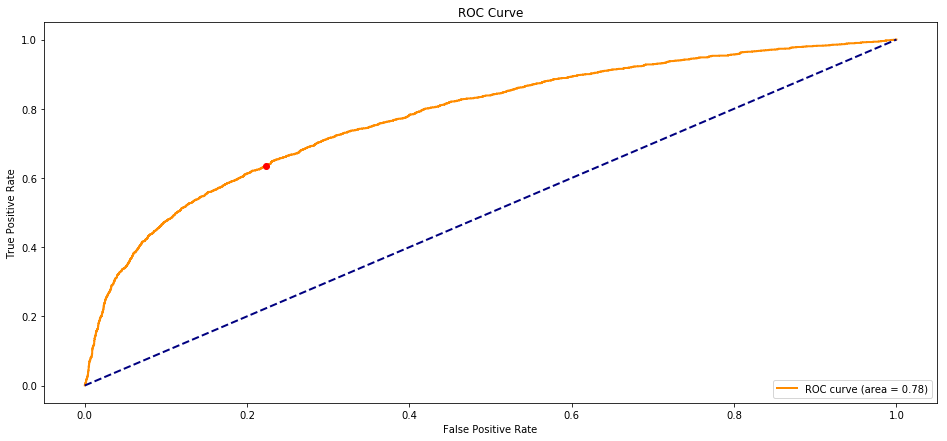

In [201]:
# parameters = {'C': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
clf = LogisticRegression(penalty='l2', C=1, class_weight='balanced', fit_intercept=True, random_state=r, n_jobs=-1)
#grid_search_cv(parameters=parameters, clf=clf, scoring='f1', dataset_name='meta')
fit_and_score(clf, 'meta')
X, y, X_test, y_test = retrieve_dataset('meta')
clf.fit(X, y)
print(X_meta.columns)
print(clf.coef_)
plot_roc_curve(clf, X_test, y_test)

# Level 2 - Gaussian Naive Bayes
- f1_cv = 0.541 ± 0.021
- f1_test = 0.533

In [202]:
clf = GaussianNB()
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.548	 f1_cv = 0.548 ± 0.022
f1_test = 0.540
cm_train = 
[[11892  2138]
 [ 1672  2310]]
cm_test = 
[[5860 1050]
 [ 848 1114]]


(CUST_COD
 14356766    1.000000
 21308338    0.000393
 54049646    0.000029
 10396398    0.001226
 11528589    0.000056
 20362183    0.000195
 45569593    0.000533
 44429180    0.000270
 52612111    0.000289
 34291217    0.000371
 22484587    0.000343
 52913781    0.000026
 59230034    0.562689
 13175350    0.000197
 12582570    0.000106
 51594012    0.000229
 35571106    0.999999
 16001040    0.000012
 57296369    0.000412
 35902487    0.000021
 33070856    0.000932
 33183607    0.001621
 34849977    0.000010
 16490032    1.000000
 58011273    0.001273
 45734499    0.000162
 56990048    0.000025
 47504826    0.999998
 30633355    1.000000
 38597549    0.000145
               ...   
 40819584    0.000236
 26731760    0.000624
 47394107    0.000638
 46272483    0.999996
 40137864    0.000157
 57671329    0.000022
 41089924    0.000009
 19657950    0.999996
 19269106    1.000000
 36031689    0.991924
 11089246    0.994423
 17220851    0.791209
 31085210    1.000000
 36179122    0.000175


# Level 2 - Decision Tree Classifier
- f1_cv = 0.572 ± 0.020
- f1_test = 0.541

In [203]:
clf = DecisionTreeClassifier(random_state=r, max_depth=1, class_weight='balanced')
fit_and_score(clf, 'meta')

Evaluating on meta dataset
f1_train = 0.574	 f1_cv = 0.574 ± 0.020
f1_test = 0.537
cm_train = 
[[11598  2432]
 [ 1403  2579]]
cm_test = 
[[5644 1266]
 [ 776 1186]]


(CUST_COD
 14356766    0.788866
 21308338    0.298845
 54049646    0.298845
 10396398    0.788866
 11528589    0.298845
 20362183    0.298845
 45569593    0.298845
 44429180    0.298845
 52612111    0.298845
 34291217    0.298845
 22484587    0.298845
 52913781    0.298845
 59230034    0.298845
 13175350    0.298845
 12582570    0.298845
 51594012    0.298845
 35571106    0.788866
 16001040    0.298845
 57296369    0.298845
 35902487    0.298845
 33070856    0.298845
 33183607    0.788866
 34849977    0.298845
 16490032    0.788866
 58011273    0.788866
 45734499    0.298845
 56990048    0.298845
 47504826    0.788866
 30633355    0.788866
 38597549    0.298845
               ...   
 40819584    0.298845
 26731760    0.298845
 47394107    0.298845
 46272483    0.788866
 40137864    0.298845
 57671329    0.298845
 41089924    0.298845
 19657950    0.788866
 19269106    0.788866
 36031689    0.788866
 11089246    0.788866
 17220851    0.788866
 31085210    0.788866
 36179122    0.298845
